RAG Framework

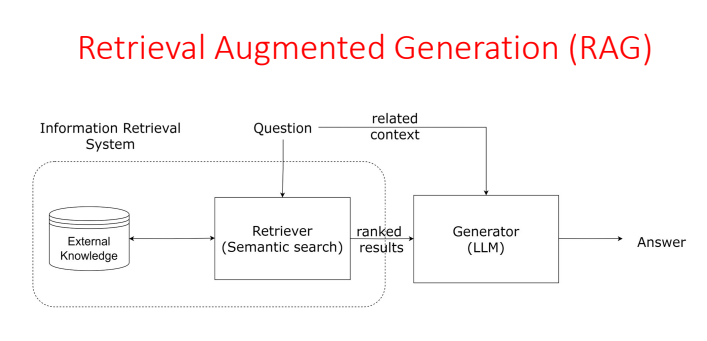

### Problem Statement
Given Climate risk related document, build an agent to answer user queries

### Part 1 - Overall Product Specifications

***Problem Statement*** - Financed Emission related Query Agent to anser users query with reference document. All related data are currently stored as separate documents a folder. Our task is to build a proper Q/A bot using RAG, that the users can interact with and get answers from.

***Solution Strategy*** - Build a POC which should solve the following requirements:

- Users would responses from Financed Emission related document knowledge base
- If they want to refer to the original document from which the bot is responding, the bot should provide a citation as well.

Goal - Solving the above two requirements well in the POC would ensure that the accuracy of the overall model is good and therefore further improvisations and customizations make sense.

***Data Used*** - Financed Emission related pdf, which includes PCAF document aling with differnt Bank's published Reports, stored in a single folder

***Tools used*** - LlamaIndex (only for now) has been used due to its powerful query engine, fast data processing using data loaders and directory readers as well as easier and faster implementation using fewer lines of code.

### Part 2 - Solution POC

In this section, we go ahead and actually build a POC of the solution that we proposed in the previous step

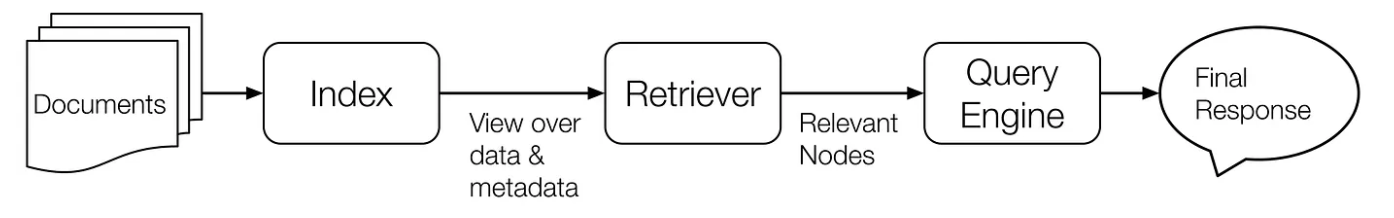

#### Documents and Nodes
Documents in LlamaIndex may be different from your traditional perception of documents. <br>
Document and Node objects are core abstractions within LlamaIndex.

A **Document** is a generic container around any data source - for instance, a PDF, an API output, or retrieved data from a database. They can be constructed manually, or created automatically via data loaders. By default, a Document stores text along with some other attributes. Some of these are

`metadata` - a dictionary of annotations that can be appended to the text (basically, additional info about the document) <br>
`relationships` - a dictionary containing relationships to other Documents/Nodes.

<br>

A **Node** represents a "chunk" of a source Document, whether that is a text chunk, an image, or other. Similar to Documents, they contain metadata and relationship information with other nodes.

Nodes are a first-class citizen in LlamaIndex. You can choose to define Nodes and all its attributes directly. You may also choose to "parse" source Documents into Nodes through our `NodeParser` classes. By default every Node derived from a Document will inherit the same metadata from that Document (e.g. a "file_name" filed in the Document is propagated to every Node).

Both Documents and Nodes have unique identifies called `ID`. These can be set automatically or manually. `ID` is generally used to identify, update, and define relationships between documents (or nodes).

For additional reading: [LlamaIndex Documentation](https://docs.llamaindex.ai/en/stable/module_guides/loading/documents_and_nodes/#documents-nodes)


In [1]:
#Load llamaindex
#!pip install llama-index

In [2]:
#!pip install pypdf


[notice] A new release of pip is available: 23.1.2 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
#!pip install openai

In [4]:
from llama_index.llms.openai import OpenAI
from llama_index.core.llms import ChatMessage
import os
import openai

In [5]:
# Set the API key

with open( "api_Key.txt", "r") as f:
    openai.api_key = ' '.join(f.readlines())

In [7]:
from llama_index.core import SimpleDirectoryReader
reader = SimpleDirectoryReader(input_dir="Data/")

In [9]:
documents = reader.load_data()
print(f"Loaded {len(documents)} docs")

Failed to load file D:\Puja\IIITB_MS\RAG\LlamaIndex_RAG\semantic spotter\Data\2023_TCFD_Report.pdf with error: RetryError[<Future at 0x269cbfef650 state=finished raised DependencyError>]. Skipping...
Failed to load file D:\Puja\IIITB_MS\RAG\LlamaIndex_RAG\semantic spotter\Data\Bank_of_America_Addendum_to_the_2023_TCFD.pdf with error: RetryError[<Future at 0x269cbe62190 state=finished raised DependencyError>]. Skipping...
Loaded 471 docs


In [10]:
#!pip install python-pptx torch transformers python-pptx Pillow -q


[notice] A new release of pip is available: 23.1.2 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
documents

[Document(id_='ab5b5457-2550-4931-801a-9d1a1f8cb88e', embedding=None, metadata={'page_label': '1', 'file_name': '240311-hsbc-carbon-reduction-plan.pdf', 'file_path': 'D:\\Puja\\IIITB_MS\\RAG\\LlamaIndex_RAG\\semantic spotter\\Data\\240311-hsbc-carbon-reduction-plan.pdf', 'file_type': 'application/pdf', 'file_size': 109217, 'creation_date': '2024-07-21', 'last_modified_date': '2024-07-21'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, text=' \n  \nCarbon Reduction Plan  \nSupplier name:  HSBC Bank plc  \nPublication date:  11 March 202 4 \nCommitment to achieving Net Zero  \nHSBC Bank plc  is committed to achieving Net Zero emissions by 2050. \nBaseline Emissions Footprint  \nBaseline emissions are a record of the greenhouse gases that have been produced in 

In [12]:
documents[2]

Document(id_='c48c2069-32cc-4d18-82ae-55fe0dc3fc7b', embedding=None, metadata={'page_label': '3', 'file_name': '240311-hsbc-carbon-reduction-plan.pdf', 'file_path': 'D:\\Puja\\IIITB_MS\\RAG\\LlamaIndex_RAG\\semantic spotter\\Data\\240311-hsbc-carbon-reduction-plan.pdf', 'file_type': 'application/pdf', 'file_size': 109217, 'creation_date': '2024-07-21', 'last_modified_date': '2024-07-21'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, text=" \n  \nDownstream Transportation  \nNot captured  \n \nSource: HSBC ESG Datapack, 20232 \nTotal Emissions  1,274,372  tCO2e  \n \nFurther clarifications in current emissions reporting  \n \n- Total Emissions excludes financed emissions. For further details of HSBC’s financed \nemissions reporting methodology, please see P5

Step 4 - Building the query engine

In [35]:
#!pip install llama-index-llms-huggingface
!pip install llama-index-embeddings-huggingface

                                              0.0/752.8 kB ? eta -:--:--
     ----------                             215.0/752.8 kB 4.4 MB/s eta 0:00:01
     -------------------------------------  747.5/752.8 kB 9.5 MB/s eta 0:00:01
     -------------------------------------- 752.8/752.8 kB 7.9 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.1.2 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [36]:
from llama_index.core.node_parser import SimpleNodeParser
from llama_index.core import VectorStoreIndex, ServiceContext

from IPython.display import display, HTML

from llama_index.embeddings.huggingface import HuggingFaceEmbedding 

In [37]:
# Initialize an OpenAI language model (llm) with specific configurations
llm = OpenAI(model="gpt-3.5-turbo", temperature=0.1) 

# loads BAAI/bge-small-en-v1.5
# intilaize our custom embeddings
embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")

# Create a ServiceContext object with default configurations
# This context incorporates required settings and services for generating vector representations
service_context = ServiceContext.from_defaults(
    llm=llm, embed_model=embed_model)

D:\Puja\IIITB_MS\venv\learning\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\pujak\AppData\Local\llama_index\models--BAAI--bge-small-en-v1.5. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
D:\Puja\IIITB_MS\venv\learning\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resu

**Node Parser**: [Node parsers](https://docs.llamaindex.ai/en/stable/module_guides/loading/node_parsers/modules/#node-parser-modules) chunk a document into nodes. There are several file-based node parsers, that will create nodes based on the type of content that is being parsed (JSON, Markdown, etc.)

However, for better manageability and efficiency in parsing, you can first split the text. This is done using splitters.<br>
**Splitters** are responsible for breaking down the text into smaller, manageable pieces, often called chunks or nodes. These chunks can be based on various criteria such as sentence boundaries, semantic similarity, or other custom rules.

#### Index
An `Index` is a data structure that allows us to quickly retrieve relevant context for a user query. For LlamaIndex, it's the core foundation for RAG use-cases.

At a high-level, `Indexes` are built from Documents. They are used to build Query Engines and Chat Engines which enables question & answer and chat over your data.

Under the hood, Indexes store data in Node objects, and expose a Retriever interface that supports additional configuration and automation.

The most common index by far is the VectorStoreIndex.

##### Using VectorStoreIndex#
Vector Stores are a key component of RAG and so you will end up using them in nearly every application you make using LlamaIndex, either directly or indirectly.

Vector stores accept a list of Node objects and build an index from it.
<br>

**Loading data into the index**

The simplest way to use a Vector Store is to load a set of documents and build an index from them using from_documents:

In [ ]:
# Create a VectorStoreIndex object by indexing the 'document' (text data) using the provided service context
index = VectorStoreIndex.from_documents(
    documents,  # List containing the document(s) to be indexed
    service_context=service_context)  # Incorporates the context for vector generation and indexing

#### Basic Query Retrieval ❔
Let's try to make a question and check the output text. We will compare later with other models.

In [13]:
# create parser and parse document into nodes
#parser = SimpleNodeParser.from_defaults()
#nodes = parser.get_nodes_from_documents(documents)
# documents --> nodes

# # build index
#index = VectorStoreIndex(documents)
#nodes --> index

# Construct Query Engine
query_engine = index.as_query_engine()

Step 5 - Checking respones and respone parameters

In [15]:
response = query_engine.query("What is this document talking about?")

In [16]:
#Checking the response
response.response

'This document is discussing the disclosure process for signatories.'

In [17]:
#Check the source node
response.source_nodes

[NodeWithScore(node=Document(id_='416a80bd-9198-45f0-9f69-8c1c0da5e48d', embedding=None, metadata={'page_label': 'II', 'file_name': 'msim_climate_report_en.pdf', 'file_path': 'D:\\Puja\\IIITB_MS\\RAG\\LlamaIndex_RAG\\semantic spotter\\Data\\msim_climate_report_en.pdf', 'file_type': 'application/pdf', 'file_size': 4897520, 'creation_date': '2024-07-21', 'last_modified_date': '2024-07-21'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, text='TABLE OF CONTENTS\n1\nIntroduction\n3\nGovernance7\nStrategy \n22\nRisk  \nManagement26\nMetrics & Targets\n29\nImportant  \nInformation', mimetype='text/plain', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'), score=0.7931268

In [18]:
#Extract the file name
response.source_nodes[0].node.metadata['file_name']

'msim_climate_report_en.pdf'

In [19]:
#Extract the score
response.source_nodes[1].score

0.7928359598358051

Step 6 - Creating a response Pipeline

User receives the response and the document that they can refer to

In [21]:
## Query response function
def query_response(user_input):
    response = query_engine.query(user_input)
    file_name = response.source_nodes[0].node.metadata['file_name']
    final_response = response.response + '\n Check further at ' + file_name + ' document'
    return final_response

In [22]:
def initialize_conv():
    print('Feel free to ask Questions regarding essays of Paul Graham. Press exit once you are done')
    while True:
        user_input = input()
        if user_input.lower() == 'exit':
            print('Exiting the program... bye')
            break
        else:
            response = query_response(user_input)
            display(HTML(f'<p style="font-size:20px">{response}</p>'))